# FinOL
## Tutorial 4: Training a Model
In Tutorial 4, we will continue building on the progress made in Tutorial 2 by utilizing the dataset ``SP500`` loaded using the techniques covered in the previous tutorial.  Now that we have successfully loaded the dataset, we will focus on training a model using these DataLoaders.

Throughout Tutorial 4, we will provide step-by-step instructions and code examples to guide you through the training process.  By the end of this tutorial, you will have a trained model that can make predictions on new data.

Make sure to refer back to Tutorial 2 if you need a refresher on loading the dataset. Once you have the DataLoaders, you are ready to proceed with training.

We first import the ``data_loader``, ``trainer``, and other necessary packages for Tutorial 3.

In [1]:
import re
import matplotlib
import matplotlib.pyplot as plt
from rich import print
from finol.data_layer.data_loader import *
from finol.optimization_layer.model_trainer import *
from finol.config import *

with open(ROOT_PATH + '/config.py', 'r') as file:
    content = file.read()

content = re.sub(r'(TUTORIAL_MODE\s*=\s*).*', r'\g<1>True', content)
content = re.sub(r'(TUTORIAL_NAME\s*=\s*").*?(")', r'\g<1>' + "TUTORIAL_4" + r'\g<2>', content)

with open(ROOT_PATH + '/config.py', 'w') as file:
    file.write(content)

The current FinOL is latest


As mentioned previously in Tutorial 2, we first load the dataset for our machine learning model using the ``load_dataset`` function.    This function takes care of loading the data from a file, parsing it, and preprocessing it to prepare it for training, validation, and testing.

In [3]:
load_dataset_output = load_dataset()
load_dataset_output

Data Loading: 100%|██████████| 26/26 [00:16<00:00,  1.61it/s]


Successfully loaded 26 Excel file(s):

Data Processing: 100%|██████████| 26/26 [00:31<00:00,  1.21s/it]


{'train_loader': <torch.utils.data.dataloader.DataLoader at 0x1bfa3a28fa0>,
 'val_loader': <torch.utils.data.dataloader.DataLoader at 0x1bfa3a28880>,
 'test_loader': <torch.utils.data.dataloader.DataLoader at 0x1bfa3a28220>,
 'NUM_TRAIN_PERIODS': 3293,
 'NUM_VAL_PERIODS': 1130,
 'NUM_TEST_PERIODS': 1131,
 'NUM_ASSETS': 26,
 'NUM_FEATURES_AUGMENTED': 1430,
 'NUM_FEATURES_ORIGINAL': 143,
 'WINDOW_SIZE': 10}

**Training the Model**

We next define a custom loss function called ``criterion`` for the following training process. In ``FinOL``, users have the flexibility to define their own custom loss functions.  This allows users to tailor the training process to their specific needs.  For example, users may want to define a custom loss function that includes risk measurement.

Following that, we implement define the model architecture with the LSTM layer, specifying the input feature and output sizes based on the dataset characteristics obtained from the data loading stage.  The model is then moved to the designated device.

An Adam optimizer is then chosen for training the network weights. In ``FinOL``, a comprehensive range of over 40 optimizers is available.

The core training loop iterates over mini-batches from the training dataloader, performs forward, backward and optimization steps at each turn.  Validation loss is also computed periodically to select the best performing model checkpoint for later deployment.

This covers the essential components involved in setting up and executing a deep learning workflow on financial data within the PyTorch framework as implemented in our tutorial.  We are now ready to kick off model training and analysis of results.

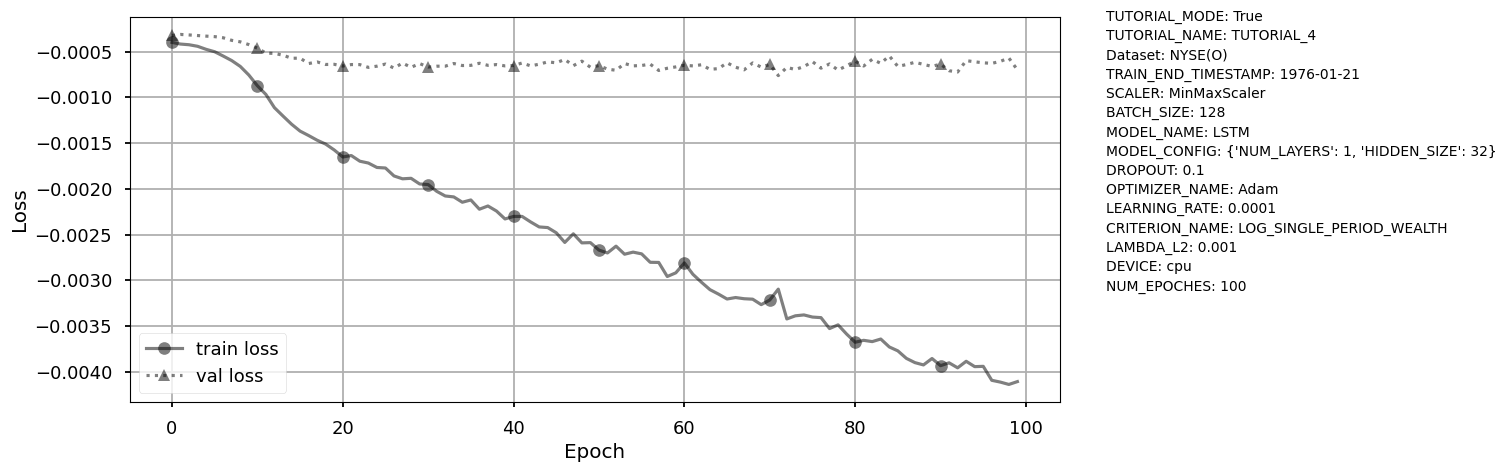

Training: 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


In [4]:
train_model_output = train_model(load_dataset_output)

The following code block uses the trained model to evaluate the performance of the model on the training data.  It calculates the daily return for each data point in the training set and then calculates the cumulative wealth over the entire training set.

In [5]:
model = train_model_output["last_model"]
model.eval()

train_loader = load_dataset_output["train_loader"]

label_list = []
portfolio_list = []
daily_return_list = []

for i, data in enumerate(train_loader, 1):
    x_data, label = data
    for t in range(x_data.shape[0]):
        x_data_t = x_data[t]
        label_t = label[t]
        x_data_t = x_data_t.unsqueeze(0)
        label_t = label_t.unsqueeze(0)

        label_t = label_t.cpu().detach().numpy()
        label_list.append(label_t)

        portfolio = model(x_data_t.float())
        portfolio = portfolio.cpu().detach().numpy()
        portfolio_list.append(portfolio)

        daily_return = np.sum(label_t * portfolio)
        daily_return_list.append(daily_return)

daily_cumulative_wealth = np.cumprod(daily_return_list)

By looking at the plotted L2 norm graph below, we can clearly see that compared to the untrained model from Tutorial 3, the outputs of the trained model have larger L2 norms.  This indicates a more concentrated (definite) investment decision.

In addition, the cumulative wealth are also much more significant.  While the untrained model from Tutorial 3 only achieved around 3 times sample period returns, the trained model achieved wealth on the order of 10 to the power of 6.

The trained model learns through training to put more emphasis on the right investments, leading to outperformance on the order of thousands compared to the previous result.  This demonstrates the value of applying data-driven technologies to optimize the OLPS task.

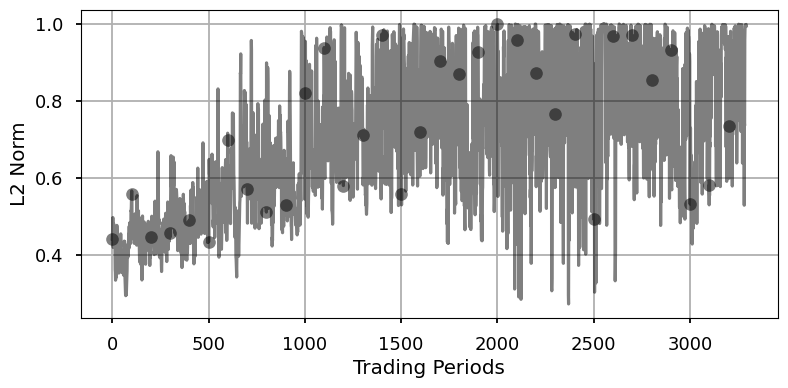

In [6]:
plt.figure(figsize=(9, 4))
l2_norm_list = []
for portfolio in portfolio_list:
    l2_norm = np.linalg.norm(portfolio, ord=2)
    l2_norm_list.append(l2_norm)

plt.xlabel('Trading Periods')
plt.ylabel('L2 Norm')
plt.grid(True)
plt.plot(l2_norm_list, marker=MARKERS[0], color='black', markevery=MARKEVERY*10, alpha=ALPHA)
plt.show()

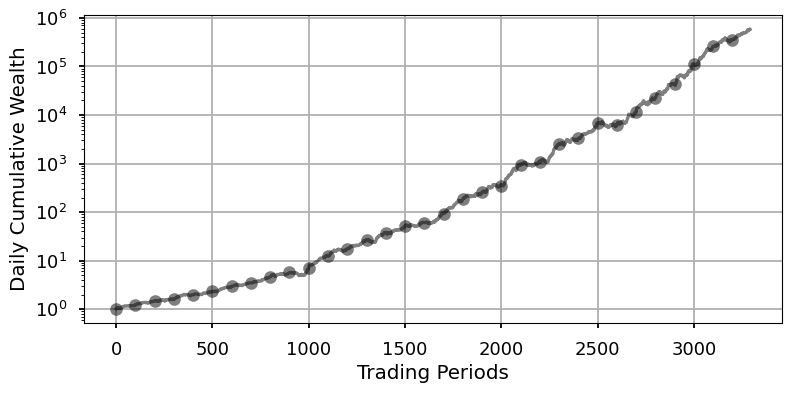

In [7]:
# In-sample daily cumulative wealth
plt.figure(figsize=(9, 4))
plt.plot(daily_cumulative_wealth, marker=MARKERS[0], color='black', markevery=MARKEVERY*10, alpha=ALPHA)
plt.xlabel('Trading Periods')
plt.ylabel('Daily Cumulative Wealth')
plt.yscale('log')
plt.grid(True)
plt.show()